In [5]:


import tensorflow as tf
from numpy import dtype 

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.environments.py_environment import PyEnvironment
from tf_agents.specs.array_spec import BoundedArraySpec
from tf_agents.environments import utils
from tf_agents.trajectories import time_step as ts
import numpy as np
from numpy import sign,cumsum
from itertools import product

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.metrics import tf_metrics
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

import tensorflow as tf
from random import randint 


'''
Suppose the agent is playing a dice game named "Running Sum Battle" as specified:

-First, the agent rolls a dice and wagers an initial x utility.
-The host rolls 6 dice in succession, creating a running sum.
-If the agent's running sum upto N dice is larger than the hosts respective sum, 
they win x utility, otherwise, they lose x utility.
-The agent is only required to commit the first roll with utility and without
information. Afterwards, they may choose to leave or continue rolling.

Example Game, where x=10.
Agent rolls a 3. Their running total is [3]
Host rolls 3,2,4,5,6,5. Their running total is [3,5,9,14,20,25]
The Agent's running total upto 1 die is not greater than Host's. They lose 10 utility.
The Agent chooses to roll again. The agent rolls a 6. Their running total is now 9.
The Agent's running total upto 2 dice is greater than Host's. They gain 10 utility.
The Agent chooses to roll again. The agent rolls a 1. Their running total is now 10.
The Agent's running total upto 3 dice is greater than Host's. They gain 10 utility.
The Agent decides to quit. They have gained 10 utility overall.

Idea: The agent will learn to roll and quit based on their running total.

'''

class RunningSumBattle(PyEnvironment):
    def __init__(self):
        host_rolls = list(cumsum([(randint(1,6)) for _ in range(0,6)]))
        player_roll = [randint(1,6)]
        current_dice = [1]
        self.restart = False
        self._state = np.array(current_dice+player_roll+host_rolls)

        
        
    def action_spec(self):
        return BoundedArraySpec(shape=(1,), dtype=np.int64, minimum=0, maximum=1, name='action')
        
    def observation_spec(self):
        return BoundedArraySpec(shape=(8,), dtype=np.int64, minimum=0, maximum=36, name='observation')
    
    def _reset(self):
        host_rolls = list(cumsum([(randint(1,6)) for _ in range(0,6)]))
        player_roll = [randint(1,6)]
        current_dice = [1]
        self.restart = False
        self._state = np.array(current_dice+player_roll+host_rolls)
        return ts.restart(self._state)
    
    def _step(self,action):
        if self.restart:
            return self._reset()
        
        reward = 10 if self._state[1] > self._state[self._state[0]+1] else -10
        quit = action[0] == 0
        
        if quit or self._state[0] == 6:
            self.restart = True
            return ts.termination(self._state, reward=reward)
        else:
            roll = randint(1,6)
            self._state[1] += roll
            self._state[0] += 1
            return ts.transition(
                self._state, 
                reward=reward,
                discount=1.0)
        
rsb = RunningSumBattle()
#utils.validate_py_environment(rsb, episodes=5)
env = tf_py_environment.TFPyEnvironment(rsb)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=(100,64))

agent = reinforce_agent.ReinforceAgent(
    env.time_step_spec(),
    env.action_spec(),
    actor_network=actor_net,
    optimizer= tf.compat.v1.train.AdamOptimizer(),
    normalize_returns=True)

agent.initialize()

buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        agent.collect_data_spec,
        batch_size=env.batch_size,
        max_length=1000
    )
steps = tf_metrics.EnvironmentSteps()
episodes = tf_metrics.NumberOfEpisodes()
averageReturn = tf_metrics.AverageReturnMetric()

data=[]
'''
Training time is roughly around 30-60 minutes? (2570s on Google Colab)
'''
for i in range(0,5000):
    p = agent.collect_policy
    env.reset()
    driver = DynamicEpisodeDriver(env,p,observers=[buffer.add_batch,steps,episodes,averageReturn],num_episodes=10)
    final_time_step, policy_state = driver.run()


    experience = buffer.gather_all()
    train_loss = agent.train(experience)
    buffer.clear()
    print("DONE",i)
    data.append((
        steps.result().numpy(),
        episodes.result().numpy(),
        float(train_loss.loss),
        averageReturn.result().numpy()))
    

Streaming output truncated to the last 5000 lines.
DONE 1
DONE 2
DONE 3
DONE 4
DONE 5
DONE 6
DONE 7
DONE 8
DONE 9
DONE 10
DONE 11
DONE 12
DONE 13
DONE 14
DONE 15
DONE 16
DONE 17
DONE 18
DONE 19
DONE 20
DONE 21
DONE 22
DONE 23
DONE 24
DONE 25
DONE 26
DONE 27
DONE 28
DONE 29
DONE 30
DONE 31
DONE 32
DONE 33
DONE 34
DONE 35
DONE 36
DONE 37
DONE 38
DONE 39
DONE 40
DONE 41
DONE 42
DONE 43
DONE 44
DONE 45
DONE 46
DONE 47
DONE 48
DONE 49
DONE 50
DONE 51
DONE 52
DONE 53
DONE 54
DONE 55
DONE 56
DONE 57
DONE 58
DONE 59
DONE 60
DONE 61
DONE 62
DONE 63
DONE 64
DONE 65
DONE 66
DONE 67
DONE 68
DONE 69
DONE 70
DONE 71
DONE 72
DONE 73
DONE 74
DONE 75
DONE 76
DONE 77
DONE 78
DONE 79
DONE 80
DONE 81
DONE 82
DONE 83
DONE 84
DONE 85
DONE 86
DONE 87
DONE 88
DONE 89
DONE 90
DONE 91
DONE 92
DONE 93
DONE 94
DONE 95
DONE 96
DONE 97
DONE 98
DONE 99
DONE 100
DONE 101
DONE 102
DONE 103
DONE 104
DONE 105
DONE 106
DONE 107
DONE 108
DONE 109
DONE 110
DONE 111
DONE 112
DONE 113
DONE 114
DONE 115
DONE 116
DONE 117
DONE

,steps,episodes,loss,averageReturn
0,24,10,0.059761,-6.0
1,46,20,-0.241720,0.0
2,85,30,0.329977,-3.0
3,107,40,0.340271,-6.0
4,141,50,0.245790,-8.0
...,...,...,...,...
4995,138220,49960,-0.188576,29.0
4996,138255,49970,-0.000927,19.0
4997,138290,49980,-0.114176,5.0
4998,138310,49990,-0.014971,-2.0


In [6]:
from pandas import DataFrame 
df = DataFrame(data,columns=["steps","episodes","loss","averageReturn"])
df.to_csv('/content/reinforce.csv')

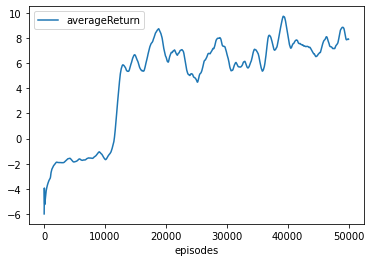

In [15]:
#The training seems to work?
newdf = df
newdf[["averageReturn"]] = newdf[["averageReturn"]].rolling(100,min_periods=1).mean()
newdf[["episodes","averageReturn"]].plot('episodes')